## LAB Assignment 4 - Linear Regression

12011404, 叶璨铭
### 4.2 建立模型预测房价
1. 加载数据集并可视化。使用 "California housing price"数据集。
2. 数据预处理，选出20%的数据作为测试集。
3. 使用线性回归、多项式回归、高斯核回归、正则化。分析模型的合理性。

#### 4.2.1 加载数据集并可视化

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display  # Allows the use of display() for DataFrames
# 'os' module provides functions for interacting with the operating system 
import os
# 'Numpy' is used for mathematical operations on large, multi-dimensional arrays and matrices
import numpy as np
# 'Pandas' is used for data manipulation and analysis
import pandas as pd
# 'Matplotlib' is a data visualization library for 2D and 3D plots, built on numpy
from matplotlib import pyplot as plt
%matplotlib inline
# 'Seaborn' is based on matplotlib; used for plotting statistical graphics
import seaborn as sns
# to suppress warnings
import warnings
# warnings.filterwarnings("ignore") 
# Pretty display for notebooks
%matplotlib inline

In [3]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(dir(housing), type(housing))

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names'] <class 'sklearn.utils._bunch.Bunch'>


In [4]:
print(housing.feature_names, housing.target_names)
housing.data.shape, housing.target.shape

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] ['MedHouseVal']


((20640, 8), (20640,))

In [ ]:
import translators as ts
print(ts.youdao(housing.DESCR, sleep_seconds=5, timeout=None, proxies=None, to_language='zh'))

Using state  server backend.


．．  _california_housing_dataset: 
 加州房市数据集 -------------------------- 
 * *数据集特征:* * 
 :实例数:20640 
 :属性数量:8个数值、预测属性和目标 
 :属性信息: -街区组中位数收入 -房屋年龄街区组中位房屋年龄 -每个家庭的平均房间数 - AveBedrms每个家庭的平均卧室数量 —人口块组人口 - AveOccup家庭成员的平均人数 —纬度块组的纬度 —经度块组经度 
 :属性值:无 
 该数据集来自StatLib存储库。 https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html 
 目标变量是加州各区房屋价值的中位数， 以几十万美元(10万美元)表示。 
 该数据集来自1990年美国人口普查，每次普查使用一行 块组。 集团是美国所拥有的最小的地理单位 人口普查局发布样本数据(一个群体通常有一个人口 600至3000人)。 
 家庭是住在一个家里的一群人。 因为平均 在这个数据集中，每户提供了房间和卧室的数量 对于家庭数很少的块组，列可能取惊人的大值 还有很多空房子，如度假胜地。 
 可以使用 : func:“sklearn.datasets。 fetch_california_housing”功能。 
 ．．  主题:引用 
 - Pace, R. Kelley和Ronald Barry，稀疏空间自回归， 统计与概率快报，33 (1997)291-297


: 

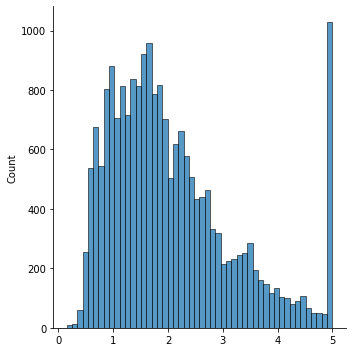

In [5]:
sns.displot(housing.target, bins=50, kde=False) 
# 注意横坐标房价的单位是10万美元。

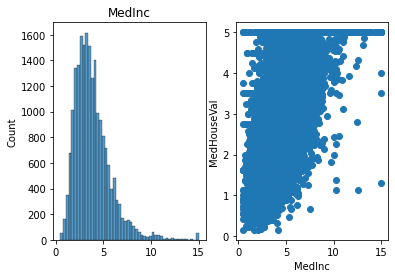

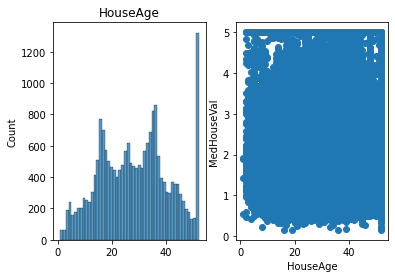

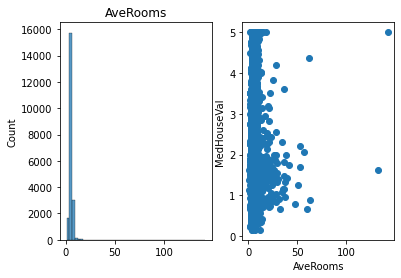

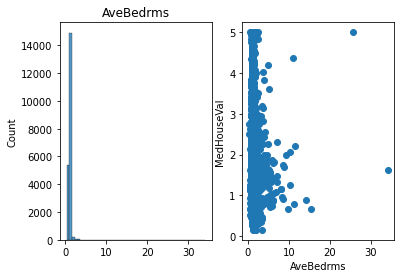

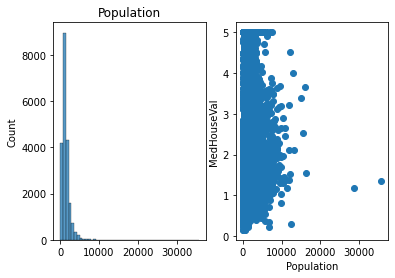

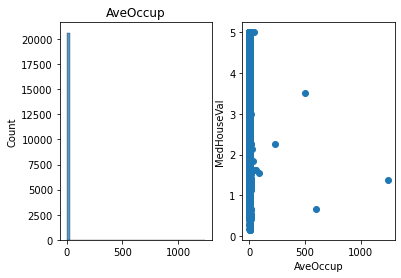

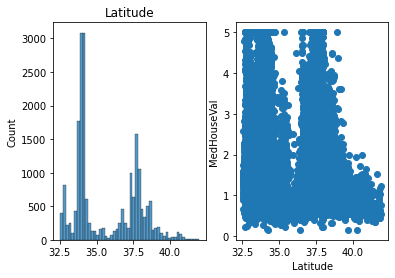

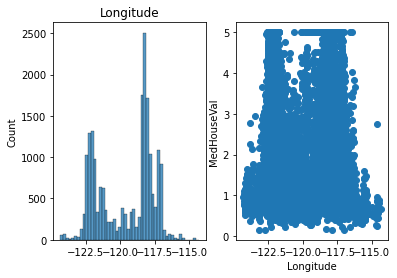

: 

In [ ]:
l = len(housing.feature_names)
for i in range(l):
    # plt.figure()
    f, ax = plt.subplots(1, 2)
    sns.histplot(housing.data[:,i], bins=50, kde=False, ax=ax[0]) 
    ax[0].set_title(housing.feature_names[i])
    # plt.figure()
    ax[1].scatter(housing.data[:,i], housing.target)
    ax[1].set_xlabel(housing.feature_names[i])
    ax[1].set_ylabel(housing.target_names[0])

In [9]:
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


<AxesSubplot: ylabel='Frequency'>

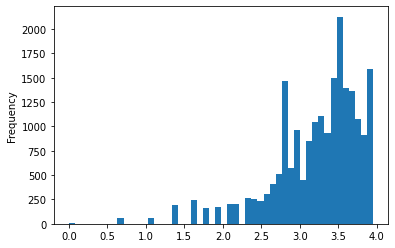

In [11]:
df['log-house-age'] = np.log(df['HouseAge'])
df['log-house-age'].plot.hist(bins=50)

<AxesSubplot: ylabel='Frequency'>

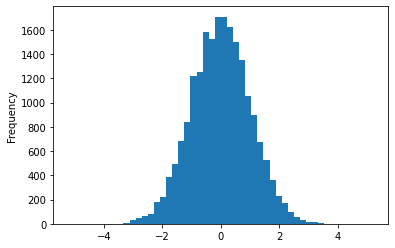

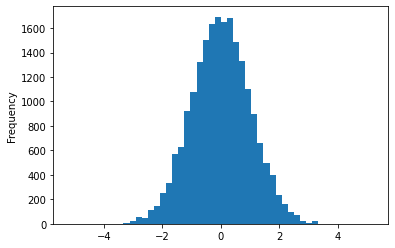

In [14]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(
    n_quantiles=500, output_distribution="normal", random_state=0
)
df['quan-latitude'] = qt.fit_transform(df['Latitude'].values.reshape(-1, 1))
df['quan-longitude'] = qt.fit_transform(df['Longitude'].values.reshape(-1, 1))
df['quan-latitude'].plot.hist(bins=50)
plt.figure()
df['quan-longitude'].plot.hist(bins=50)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
def evaluate(pipeline, data, target):
    X_train, X_test, y_train, y_test = train_test_split(data, target)
    pipeline.fit(X_train, y_train)
    scores = cross_val_score(pipeline, X_train, y_train) # 没有指定estimator，使用模型默认的estimator，就是R2。
    return scores.mean()

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
simple = Pipeline([('lin_reg', LinearRegression())])
std = Pipeline([('std_scaler', StandardScaler()), ('lin_reg', LinearRegression())])
poly = Pipeline([('poly', PolynomialFeatures(degree=2)), ('lin_reg', LinearRegression())])
poly_reg = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                     ('std_scaler', StandardScaler()),
                     ('lin_reg', LinearRegression())])
pipelines = [simple, std, poly, poly_reg]

In [18]:
original = (housing.data, housing.target)
not_outlier = (housing.data[housing.target<4.8], housing.target[housing.target<4.8])
df_processed = (df.drop(['HouseAge', 'Latitude', 'Longitude'], axis=1).values, housing.target)
datasets = [original, not_outlier, df_processed]

In [19]:
def get_evalated(pipelines, datasets):
    val_scores = {(i, j):evaluate(pipeline, *dataset) for i, pipeline in enumerate(pipelines) for j, dataset in enumerate(datasets)}
    print(val_scores)

In [20]:
get_evalated(pipelines, datasets)

{(0, 0): 0.6023686533788745, (0, 1): 0.513420121624719, (0, 2): 0.09775613750285313, (1, 0): 0.5199672184718775, (1, 1): 0.5556274642560651, (1, 2): -0.3941629625149211, (2, 0): -17.008627937982702, (2, 1): -7.144478661280483, (2, 2): -50.104078220697474, (3, 0): -1.3084875864967358, (3, 1): -7.9019813510700105, (3, 2): -42.94625298154318}


In [ ]:
# 得出结论：
# 1. 去除异常值后，多项式回归效果提高。
# 2. 正则化是有效的。
# 3. 多项式特征没有用。根据我们上面数据预处理画的图，我们发现数据本身不是很高阶的多项式，而是比较线性的。

In [59]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
ridge_poly = Pipeline([('poly', PolynomialFeatures()), ('std_scaler', StandardScaler()), ('ridge_reg', Ridge())])
grid_ridge_poly = GridSearchCV(ridge_poly, param_grid={'poly__degree': [1, 2, 3, 4], 'ridge_reg__alpha': [0.1, 1, 10]}, cv=5)
pipelines = [std, grid_ridge_poly]
datasets = [not_outlier]
get_evalated(pipelines, datasets)

{(0, 0): 0.5727049351195597, (1, 0): 0.5014203978560362}


In [ ]:
# 可以看到，使用Ridge回归后，不管GridSearchCV选择的是哪个超参数，都比原来的模型效果差。
# 结论：Ridge回归不适合这个数据集。

In [60]:
# 最后，我们在测试集上跑一下
X_train, X_test, y_train, y_test = train_test_split(*not_outlier)
std.fit(X_train, y_train)
std.score(X_test, y_test)

0.5694270033100297

In [ ]:
# 可以看出，测试集上的分数和交叉验证集上的分数差不多，说明交叉验证是个很有效的方法。

### 4.3 Questions
1) Describe another real-world application where the regression method can be applied
2) What are the strengths of the linear/polynomial regression methods; when do they perform well?
3) What are the weaknesses of the linear/polynomial regression methods; when do they perform poorly?
4) What makes the linear regression method a good candidate for the regression problem, if you have enough knowledge about the data?

1. 预测南科大的泰晤士排名、根据笔记本配置预测淘宝上的价格、根据古代玻璃文物风化后的化学成分含量预测风化前化学成分的含量。
2. 好处是容易训练、可解释性强（权重的大小是特征对目标的重要程度）。当数据集较小、特征较少时，线性回归的效果较好。
3. 缺点是对非线性数据拟合不好。当数据集较大、特征较多时，线性回归的效果较差。
4. 如果了解到数据集是线性的，那么线性回归是一个很好的选择。

 <center><font size=10> Well done!👏 You have made it. </font></center>